# OLD NEEDS UPDATE TO GET DATA FROM SQL

# Heat Pump Fault Detection & Visualization

**Runs FDD on all heat pumps** using Brick-mapped YAML rules from this repo (`./rules/`).

**Config:** Uses `config.py` for paths and ROLLING_WINDOW. **Same code as `run_all.ps1`:** imports `run_fdd.run_fdd_pipeline()` directly — Brick model, rules, and FDD logic are shared.

| Rule | Flag | Description |
|------|------|-------------|
| `hp_discharge_cold_when_heating` | `hp_discharge_cold_flag` | Discharge cold when fan on + zone cold |
| `bad_sensor_check` | `bad_sensor_flag` | sat, zt out of bounds |
| `sensor_flatline` | `flatline_flag` | Sensor stuck |

**Workflow:** Load data → resolve Brick TTL → run rules on each equipment → aggregate fault counts → visualize events & discharge air.


In [110]:
from pathlib import Path
import sys
import open_fdd
import numpy as np
import pandas as pd

ROOT = Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from config import RULES_ROOT, HEAT_PUMPS_CSV, BRICK_TTL

RULES = RULES_ROOT
CSV_PATH = HEAT_PUMPS_CSV
TTL_PATH = BRICK_TTL

assert RULES.exists(), "Missing ./rules"
assert CSV_PATH.exists(), "Run pipeline first: .\\run_all.ps1"

print(f"Rules: {RULES} (from config.RULES_ROOT)")
print(f"Data:  {CSV_PATH} (from config.HEAT_PUMPS_CSV)")


Rules: C:\Users\ben\Documents\open-fdd-datalake\rules (from config.RULES_ROOT)
Data:  C:\Users\ben\Documents\open-fdd-datalake\data\heat_pumps.csv (from config.HEAT_PUMPS_CSV)


In [111]:
rule_files = sorted(RULES.glob("*.yaml"))
print("Loaded rules:", [f.name for f in rule_files])


Loaded rules: ['hp_discharge_cold_when_heating.yaml', 'sensor_bounds.yaml', 'sensor_flatline.yaml']


In [112]:
# Brick workflow: load data, resolve TTL, run rules (see next cell)
# open-fdd has no run_all_rules(); we use RuleRunner + brick_resolver


In [113]:
# ----- Run FDD using run_fdd.py (same Brick model, rules, config) -----
from run_fdd import run_fdd_pipeline

summary, result_by_eq, column_map, rules, flag_cols = run_fdd_pipeline()

flag_cols_present = [c for c in flag_cols if c in summary.columns]
print("=" * 70)
print("Fault counts per equipment (all heat pumps)")
print("=" * 70)
display(summary.style.background_gradient(subset=flag_cols_present, cmap="YlOrRd"))
print(f"\nFlag columns: {flag_cols}")
print("Total fault samples across all equipment:")
for col in flag_cols:
    print(f"  {col}: {int(summary[col].sum())}")

# Pick equipment for viz: most faults (or first if none)
if len(summary) > 0:
    totals = summary[flag_cols_present].sum(axis=1)
    eq_id = summary.loc[totals.idxmax(), "equipment_id"]
    result = result_by_eq[eq_id]
    print(f"\n→ Detail viz: {eq_id} ({len(result)} rows)")
else:
    eq_id = None
    result = pd.DataFrame()
    print("\n→ No equipment with enough data for viz")


Fault counts per equipment (all heat pumps)


,equipment_id,rows,hp_discharge_cold_flag,bad_sensor_flag,flatline_flag
0,hp_A100_3,6585,0,0,0
1,hp_A100_57,6585,0,0,0
2,hp_A101R_1,6585,0,0,0
3,hp_A101_2,6585,0,0,0
4,hp_A101_56,6585,0,0,0
5,hp_A102_5,6585,0,0,0
6,hp_A103_4,6585,0,0,0
7,hp_A104_6,6585,0,0,33
8,hp_A108_63,6586,0,0,0
9,hp_A118A_43,6585,0,0,94



Flag columns: ['hp_discharge_cold_flag', 'bad_sensor_flag', 'flatline_flag']
Total fault samples across all equipment:
  hp_discharge_cold_flag: 283
  bad_sensor_flag: 0
  flatline_flag: 4185

→ Detail viz: hp_C103_7 (13169 rows)


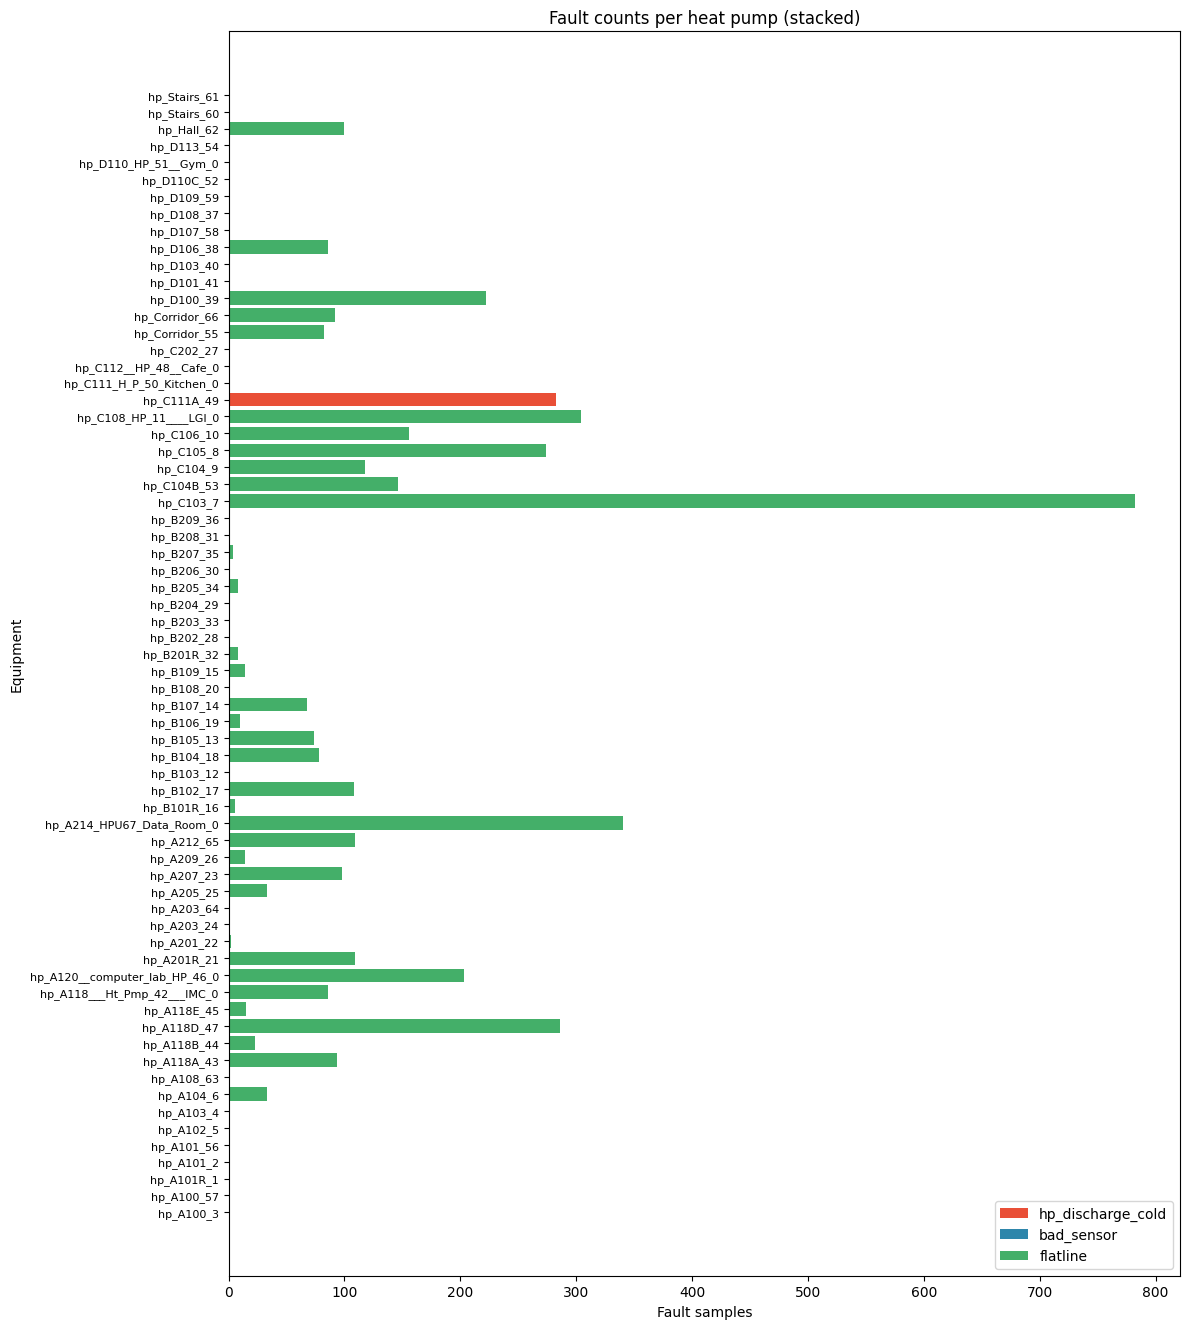

In [114]:
# ----- Per-equipment fault bar chart (stacked) -----
import matplotlib.pyplot as plt
import numpy as np

if len(summary) == 0:
    print("No equipment data.")
else:
    fig, ax = plt.subplots(figsize=(12, max(6, len(summary) * 0.2)))
    y_pos = np.arange(len(summary))
    bottom = np.zeros(len(summary))
    colors = ["#e94f37", "#2e86ab", "#44af69"]
    for i, col in enumerate(flag_cols_present):
        vals = summary[col].values
        ax.barh(y_pos, vals, left=bottom, label=col.replace("_flag", ""), color=colors[i % len(colors)])
        bottom += vals
    ax.set_yticks(y_pos)
    ax.set_yticklabels(summary["equipment_id"], fontsize=8)
    ax.set_xlabel("Fault samples")
    ax.set_ylabel("Equipment")
    ax.legend(loc="lower right")
    ax.set_title("Fault counts per heat pump (stacked)")
    plt.tight_layout()
    plt.show()

## Detail view: discharge air (selected equipment)

Rolling avg, min, max of discharge air temp (`sat`). Same plot, different colors.

Plotting: hp_C103_7 — change eq_id_to_plot to zoom on any HP (e.g. 'hp_C103_7')
Across all heat pumps: MIN sat = hp_A207_23 (37.2°F), MAX sat = hp_D107_58 (113.5°F)


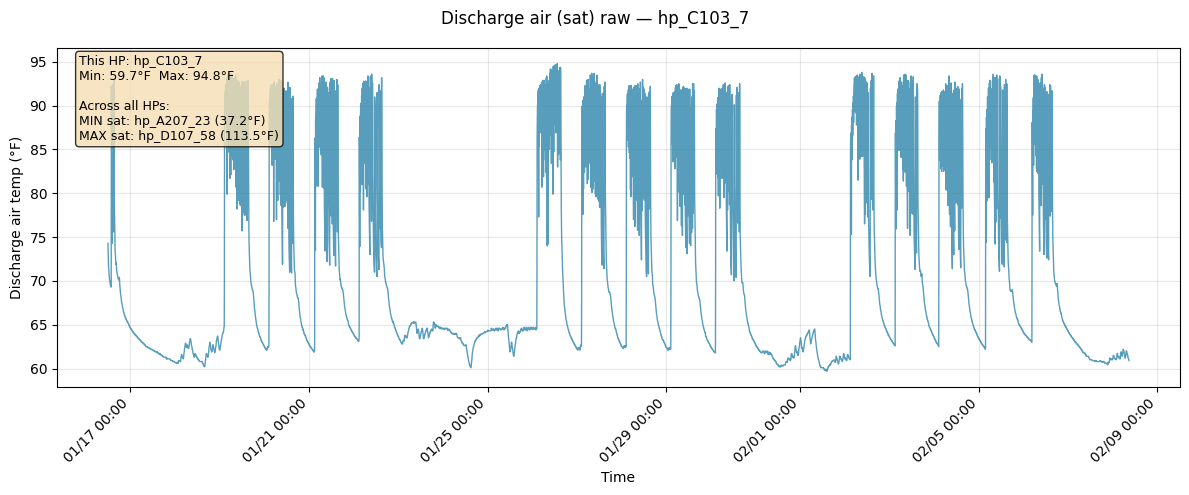

In [115]:
# ----- Discharge air: avg, min, max (rolling) on same plot -----
# To zero in on a specific HP: set eq_id_to_plot = "hp_C103_7" (or any key from result_by_eq)
eq_id_to_plot = eq_id  # default: equipment with most faults. Change to zoom on another HP.
result_plot = result_by_eq.get(eq_id_to_plot, result)
print(f"Plotting: {eq_id_to_plot} — change eq_id_to_plot to zoom on any HP (e.g. 'hp_C103_7')")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = result_plot[["timestamp", "sat"]].dropna(subset=["sat"]).sort_values("timestamp").reset_index(drop=True)
ts = df["timestamp"]

# Across ALL heat pumps: which has the lowest/highest discharge temp?
hp_min_sat = hp_max_sat = None
val_min_sat = float("inf")
val_max_sat = float("-inf")
for eid, res in result_by_eq.items():
    s = res["sat"].dropna()
    if len(s) == 0:
        continue
    mn, mx = s.min(), s.max()
    if mn < val_min_sat:
        val_min_sat = mn
        hp_min_sat = eid
    if mx > val_max_sat:
        val_max_sat = mx
        hp_max_sat = eid

print(f"Across all heat pumps: MIN sat = {hp_min_sat} ({val_min_sat:.1f}°F), MAX sat = {hp_max_sat} ({val_max_sat:.1f}°F)")

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(ts, df["sat"], color="#2e86ab", linewidth=1, alpha=0.8)
ax.set_ylabel("Discharge air temp (°F)")
ax.set_xlabel("Time")
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
fig.suptitle(f"Discharge air (sat) raw — {eq_id_to_plot}")
# This equipment + cross-dataset min/max HPs
global_min, global_max = df["sat"].min(), df["sat"].max()
txt = f"This HP: {eq_id_to_plot}\nMin: {global_min:.1f}°F  Max: {global_max:.1f}°F\n\nAcross all HPs:\nMIN sat: {hp_min_sat} ({val_min_sat:.1f}°F)\nMAX sat: {hp_max_sat} ({val_max_sat:.1f}°F)"
ax.text(0.02, 0.98, txt, transform=ax.transAxes, fontsize=9, verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))
plt.tight_layout()
plt.show()

## Zoom: hp_C111A_49 (283 hp_discharge_cold faults)

Discharge air for this HP — getting many "discharge cold when heating" hits.

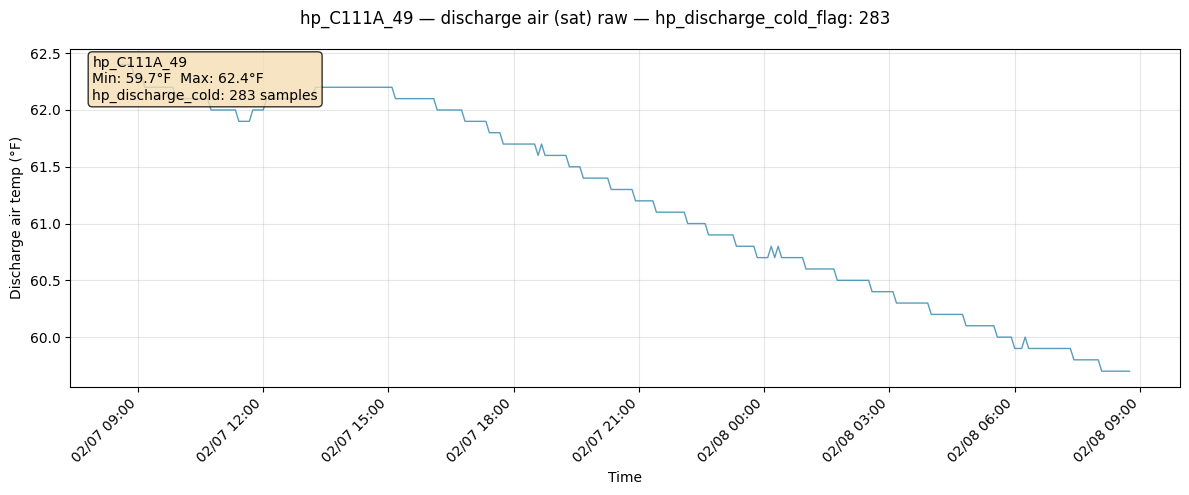

In [116]:
# ----- Zoom on hp_C111A_49 (hp_discharge_cold hits) -----
ZOOM_HP = "hp_C111A_49"
res = result_by_eq.get(ZOOM_HP)
if res is None:
    print(f"{ZOOM_HP} not in result_by_eq.")
else:
    n_cold = int(res["hp_discharge_cold_flag"].sum()) if "hp_discharge_cold_flag" in res.columns else 0
    df = res[["timestamp", "sat"]].dropna(subset=["sat"]).sort_values("timestamp").reset_index(drop=True)
    ts = df["timestamp"]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(ts, df["sat"], color="#2e86ab", linewidth=1, alpha=0.8)
    ax.set_ylabel("Discharge air temp (°F)")
    ax.set_xlabel("Time")
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    fig.suptitle(f"{ZOOM_HP} — discharge air (sat) raw — hp_discharge_cold_flag: {n_cold}")
    global_min, global_max = df["sat"].min(), df["sat"].max()
    ax.text(0.02, 0.98, f"{ZOOM_HP}\nMin: {global_min:.1f}°F  Max: {global_max:.1f}°F\nhp_discharge_cold: {n_cold} samples",
            transform=ax.transAxes, fontsize=10, verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))
    plt.tight_layout()
    plt.show()

## HP performance: % time out of comfort band (fan on only)

Worse performers = higher % of time discharge air is outside 69–73°F when fan is on. Single metric, sorted worst → best.

Worst (most time out of 69.0–73.0°F when fan on): hp_C111A_49 (100.0%)
Best: hp_B101R_16 (30.1%)


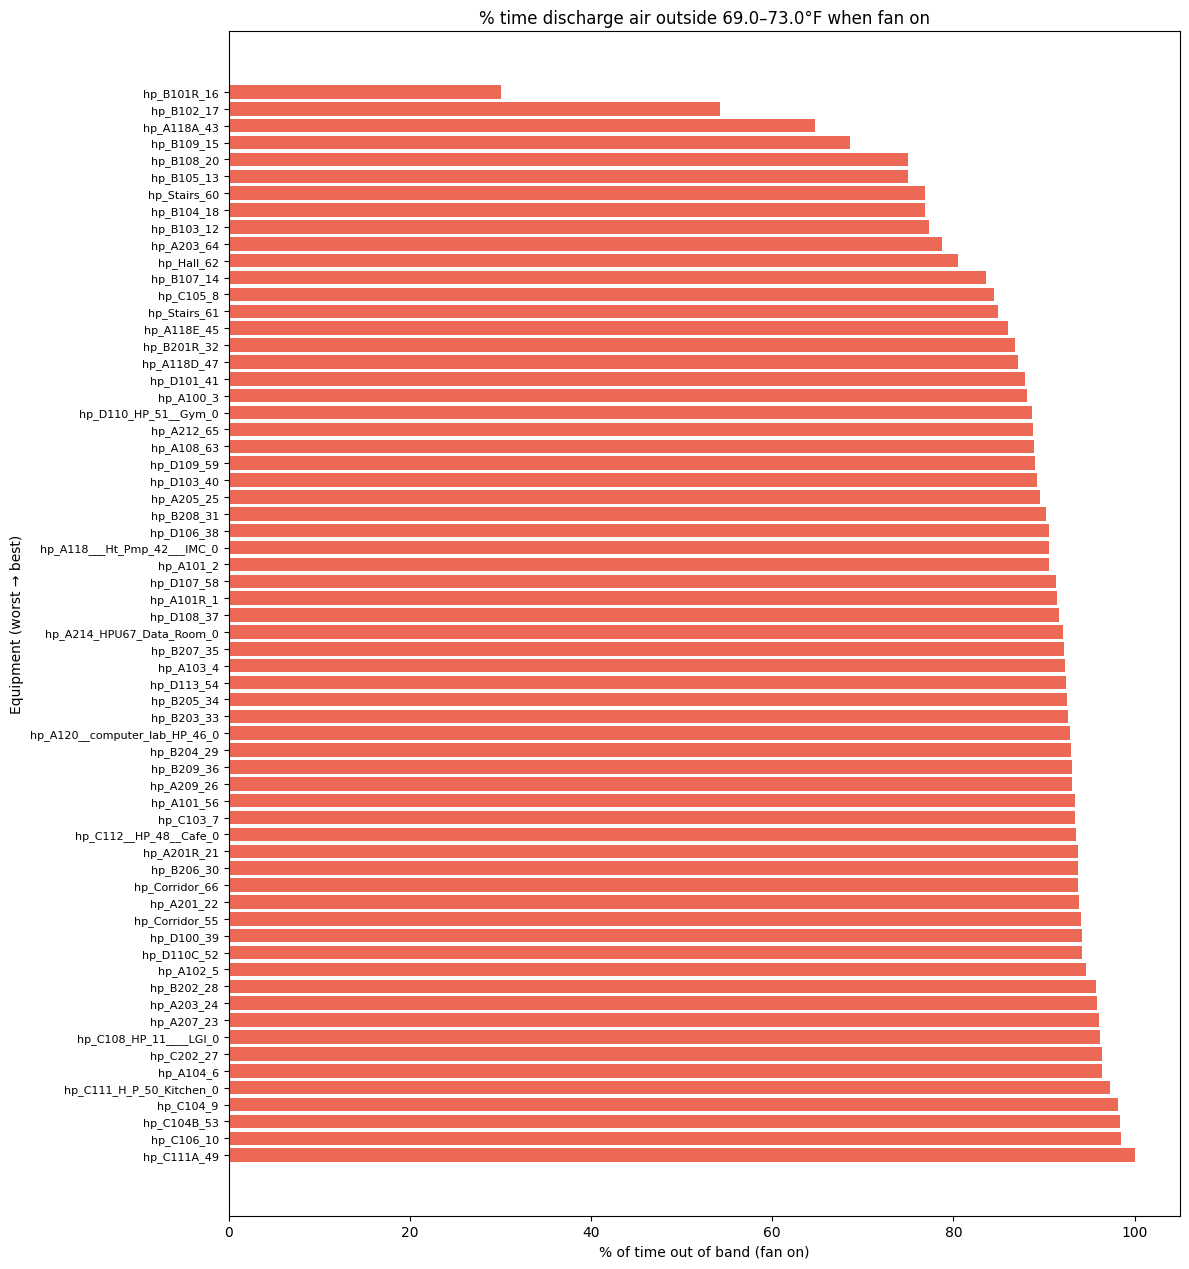

In [117]:
# ----- Rank HPs by % time out of comfort band (fan on) — single bar -----
FAN_ON_THRESHOLD = 0.01
SAT_LO, SAT_HI = 69.0, 73.0  # comfort band (°F)

rank_rows = []
for eid, res in result_by_eq.items():
    mask = (res["fan_status"] > FAN_ON_THRESHOLD) & res["sat"].notna()
    s = res.loc[mask, "sat"]
    if len(s) < 10:
        continue
    n_total = len(s)
    n_out = ((s < SAT_LO) | (s > SAT_HI)).sum()
    pct_out = 100 * n_out / n_total
    rank_rows.append({"equipment_id": eid, "pct_out_band": pct_out, "n_total": n_total})

rank_df = pd.DataFrame(rank_rows).sort_values("pct_out_band", ascending=False).reset_index(drop=True)
if len(rank_df) > 0:
    print(f"Worst (most time out of {SAT_LO}–{SAT_HI}°F when fan on): {rank_df.iloc[0]['equipment_id']} ({rank_df.iloc[0]['pct_out_band']:.1f}%)")
    print(f"Best: {rank_df.iloc[-1]['equipment_id']} ({rank_df.iloc[-1]['pct_out_band']:.1f}%)")

if len(rank_df) == 0:
    print("No data for ranking.")
else:
    fig, ax = plt.subplots(figsize=(12, max(6, len(rank_df) * 0.2)))
    y_pos = np.arange(len(rank_df))
    ax.barh(y_pos, rank_df["pct_out_band"], color="#e94f37", alpha=0.85)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(rank_df["equipment_id"], fontsize=8)
    ax.set_xlabel("% of time out of band (fan on)")
    ax.set_ylabel("Equipment (worst → best)")
    ax.set_title(f"% time discharge air outside {SAT_LO}–{SAT_HI}°F when fan on")
    plt.tight_layout()
    plt.show()

## Fault events & zoom

Contiguous runs of `True` in each flag column. Random sample of events with zoomed time window.

## Entire dataset: discharge air

All heat pumps combined — rolling avg/min/max of discharge air temp across the full building.

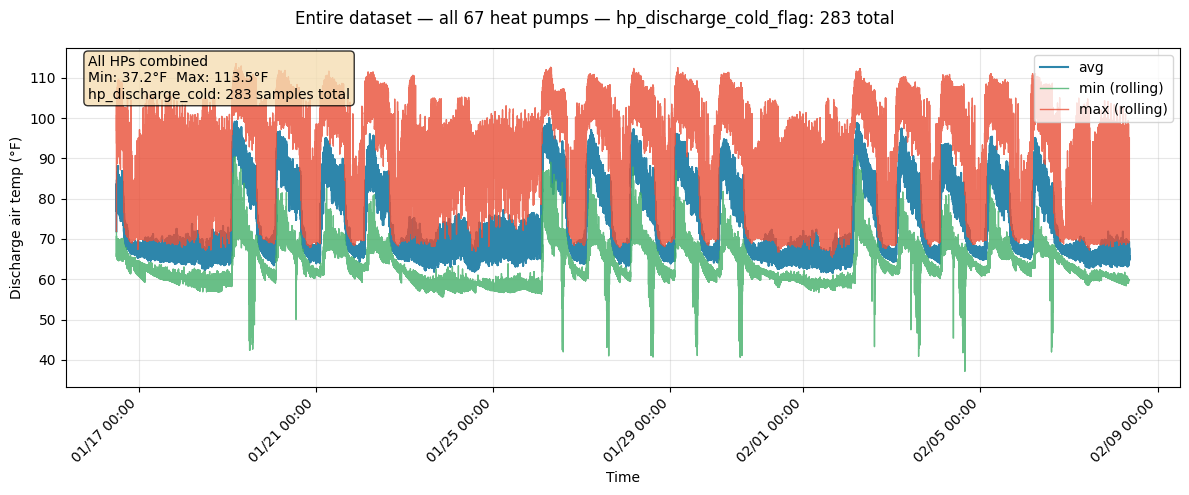

In [118]:
# ----- Entire dataset: discharge air (all HPs combined) -----
all_sat = []
total_cold = 0
for eid, res in result_by_eq.items():
    if "sat" in res.columns and "timestamp" in res.columns:
        df_part = res[["timestamp", "sat"]].dropna(subset=["sat"])
        all_sat.append(df_part)
        if "hp_discharge_cold_flag" in res.columns:
            total_cold += int(res["hp_discharge_cold_flag"].sum())
if len(all_sat) == 0:
    print("No sat data.")
else:
    df_all = pd.concat(all_sat, ignore_index=True).sort_values("timestamp").reset_index(drop=True)
    ROLLING = 24
    sat_avg = df_all["sat"].rolling(ROLLING, min_periods=1).mean()
    sat_min_roll = df_all["sat"].rolling(ROLLING, min_periods=1).min()
    sat_max_roll = df_all["sat"].rolling(ROLLING, min_periods=1).max()
    ts = df_all["timestamp"]

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(ts, sat_avg, color="#2e86ab", linewidth=1.5, label="avg")
    ax.plot(ts, sat_min_roll, color="#44af69", alpha=0.8, linewidth=1, label="min (rolling)")
    ax.plot(ts, sat_max_roll, color="#e94f37", alpha=0.8, linewidth=1, label="max (rolling)")
    ax.set_ylabel("Discharge air temp (°F)")
    ax.set_xlabel("Time")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    fig.suptitle(f"Entire dataset — all {len(result_by_eq)} heat pumps — hp_discharge_cold_flag: {total_cold} total")
    global_min, global_max = df_all["sat"].min(), df_all["sat"].max()
    ax.text(0.02, 0.98, f"All HPs combined\nMin: {global_min:.1f}°F  Max: {global_max:.1f}°F\nhp_discharge_cold: {total_cold} samples total",
            transform=ax.transAxes, fontsize=10, verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))
    plt.tight_layout()
    plt.show()

In [119]:
# ----- Convert fault flags into contiguous fault events -----
from open_fdd.reports import all_fault_events

# events = list of (start_iloc, end_iloc, flag_name)
events = all_fault_events(result, flag_cols)
print("Total events:", len(events))
# Show first 10: (start, end, flag_name)
for e in events[:10]:
    print(f"  {e[2]}: rows {e[0]}-{e[1]}")


Total events: 16
  flatline_flag: rows 513-555
  flatline_flag: rows 740-744
  flatline_flag: rows 2410-2474
  flatline_flag: rows 2545-2588
  flatline_flag: rows 2660-2749
  flatline_flag: rows 4486-4577
  flatline_flag: rows 4734-4762
  flatline_flag: rows 6560-6582
  flatline_flag: rows 7099-7141
  flatline_flag: rows 7326-7330


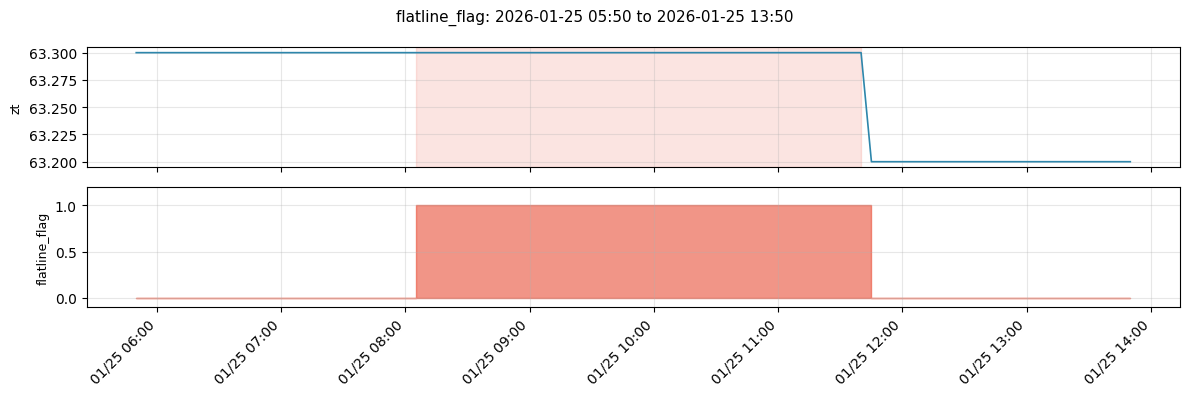

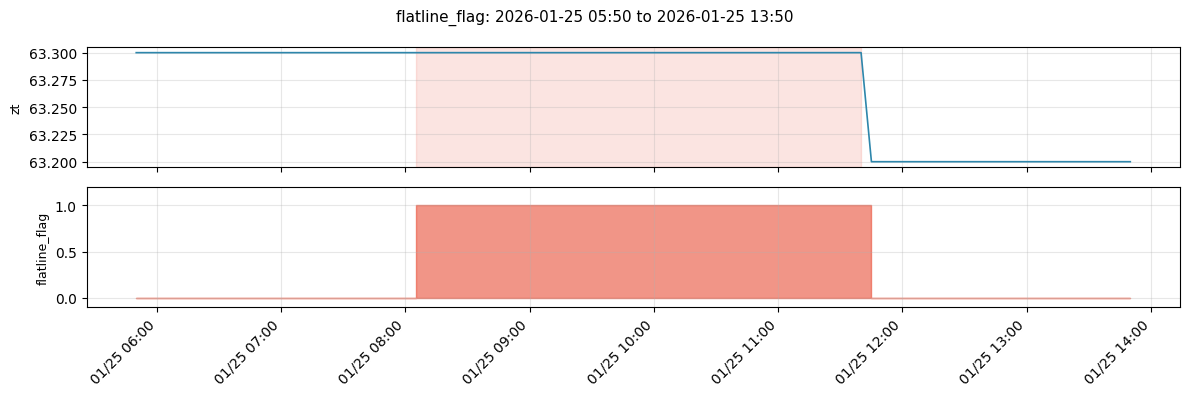

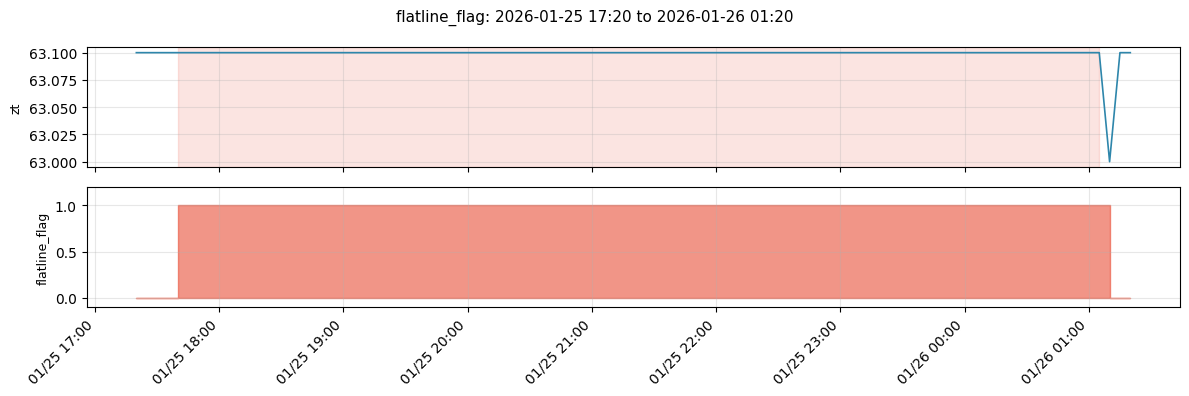

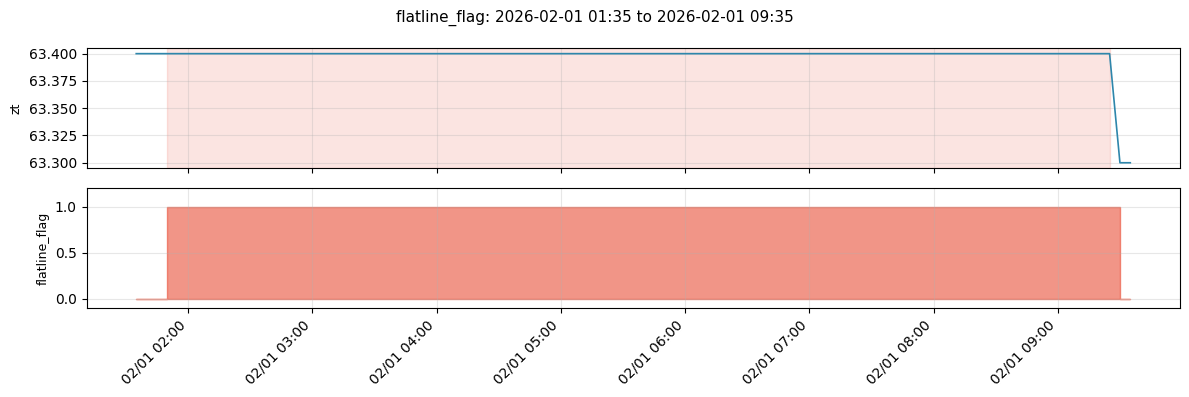

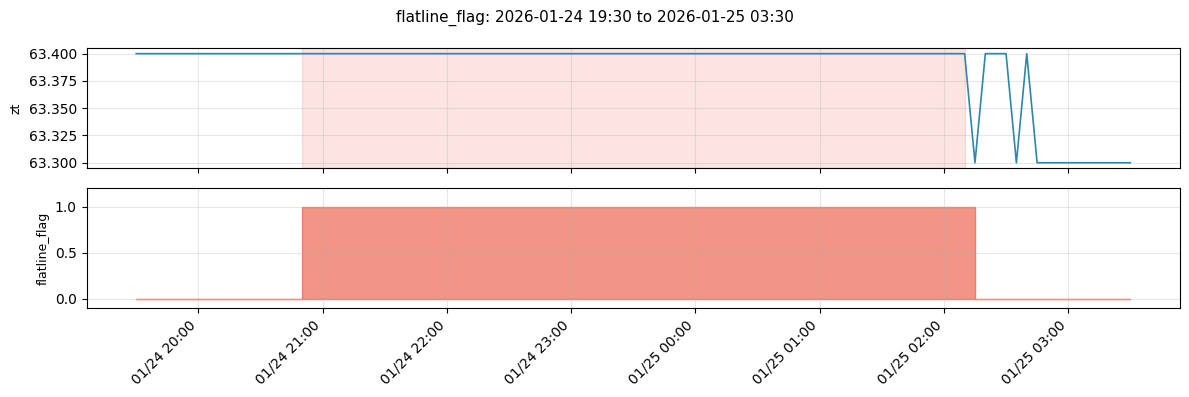

In [120]:
# ----- Zoom in on a few random events -----
import random
import matplotlib.pyplot as plt

from open_fdd.reports import build_rule_sensor_mapping, zoom_on_event

rule_to_sensors, rule_by_flag = build_rule_sensor_mapping(rules, result, column_map)

if len(events) == 0:
    print("No events to plot.")
else:
    sample = random.sample(events, min(5, len(events)))
    for ev in sample:
        fig = zoom_on_event(
            result,
            ev,
            pad=48,
            rule_to_sensors=rule_to_sensors,
            rule_by_flag=rule_by_flag,
            column_map=column_map,
            fallback_cols=["sat", "zt", "fan_status"],
        )
        plt.show()


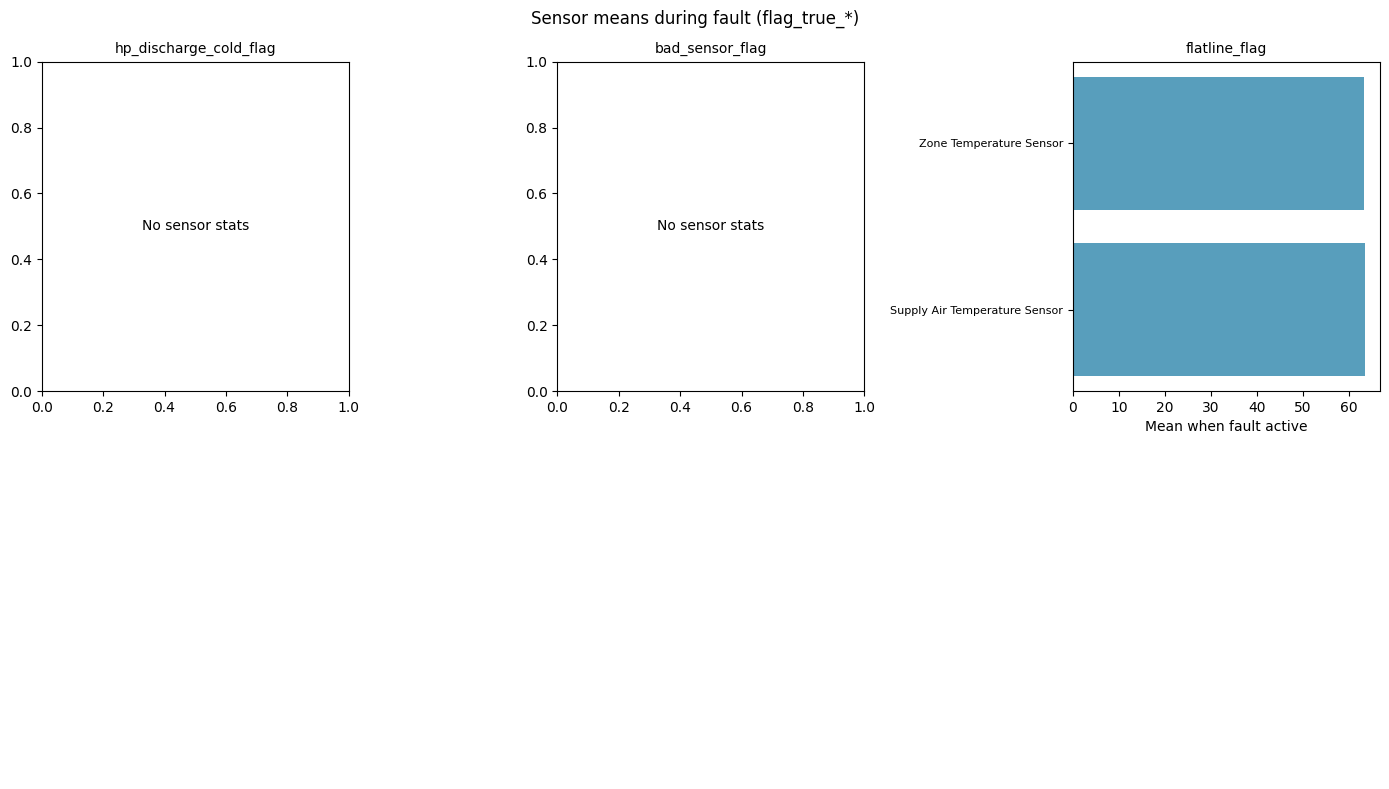

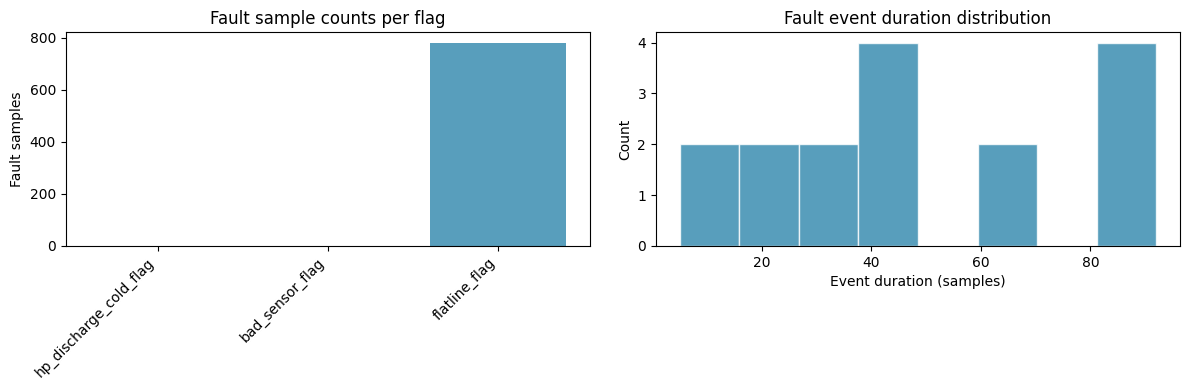

In [121]:
# ----- Analytics summary plots -----
from open_fdd.reports import run_fault_analytics, plot_fault_analytics, plot_flag_true_bars

# Deduplicate timestamps (run_fault_analytics fails with non-unique index)
result_unique = result.drop_duplicates(subset=["timestamp"]).reset_index(drop=True)
summaries = run_fault_analytics(result_unique, flag_cols, rules, column_map)

plot_flag_true_bars(summaries, flag_cols)
plot_fault_analytics(result, flag_cols, events, summaries)


## Analytics summary

Sensor means during fault, fault sample counts, event duration distribution.

## Build docx report for client

Saves Word report to `reports/heat_pump_report.docx` with building info, fault summary table, HP performance ranking, and chart.

In [122]:
# ----- Build docx for client -----
from build_report import build_report
from config import SITE_NAME, BUILDING

path = build_report(
    summary, result_by_eq,
    site_name=SITE_NAME, building=BUILDING,
    rules=rules, column_map=column_map, flag_cols=flag_cols,
)
print(f"Report saved: {path}")

Report saved: C:\Users\ben\Documents\open-fdd-datalake\reports\heat_pump_report.docx
